<center><img src='https://raw.githubusercontent.com/Jangrae/img/master/ml_python.png' width=600/></center>

# 실습 내용

- AirQuality 데이터어 데해 모델링합니다.
- KNN 알고리즘을 사용해 모델링합니다.

# 1.환경 준비

- 기본 라이브러리와 대상 데이터를 가져와 이후 과정을 준비합니다.

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [2]:
# 데이터 읽어오기
path = 'https://raw.githubusercontent.com/Jangrae/csv/master/airquality_simple.csv'
data = pd.read_csv(path)

# 2.데이터 이해

- 분석할 데이터를 충분히 이해할 수 있도록 다양한 탐색 과정을 수행합니다.

In [3]:
# 상위 몇 개 행 확인
data.head()

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41,190.0,7.4,67,5,1
1,36,118.0,8.0,72,5,2
2,12,149.0,12.6,74,5,3
3,18,313.0,11.5,62,5,4
4,19,NaN,14.3,56,5,5


In [4]:
# 기초통계량 확인
data.describe()

,Ozone,Solar.R,Wind,Temp,Month,Day
count,153.000000,146.000000,153.000000,153.000000,153.000000,153.000000
mean,42.052288,185.931507,9.957516,77.882353,6.993464,15.803922
std,30.156127,90.058422,3.523001,9.465270,1.416522,8.864520
min,1.000000,7.000000,1.700000,56.000000,5.000000,1.000000
25%,20.000000,115.750000,7.400000,72.000000,6.000000,8.000000
50%,34.000000,205.000000,9.700000,79.000000,7.000000,16.000000
75%,59.000000,258.750000,11.500000,85.000000,8.000000,23.000000
max,168.000000,334.000000,20.700000,97.000000,9.000000,31.000000


In [5]:
# NaN 값 확인
data.isnull().sum()

Ozone      0
Solar.R    7
Wind       0
Temp       0
Month      0
Day        0
dtype: int64

In [6]:
# 상관관계 확인
data.corr()

,Ozone,Solar.R,Wind,Temp,Month,Day
Ozone,1.000000,0.280068,-0.605478,0.683372,0.174197,0.004419
Solar.R,0.280068,1.000000,-0.056792,0.275840,-0.075301,-0.150275
Wind,-0.605478,-0.056792,1.000000,-0.457988,-0.178293,0.027181
Temp,0.683372,0.275840,-0.457988,1.000000,0.420947,-0.130593
Month,0.174197,-0.075301,-0.178293,0.420947,1.000000,-0.007962
Day,0.004419,-0.150275,0.027181,-0.130593,-0.007962,1.000000


# 3.데이터 준비

- 전처리 과정을 통해 머신러닝 알고리즘에 사용할 수 있는 형태의 데이터를 준비합니다.

**1) 결측치 처리**

- 시계열 데이터이므로 선형보간법으로 채웁니다.

In [7]:
# 결측치 확인
data.isnull().sum()

Ozone      0
Solar.R    7
Wind       0
Temp       0
Month      0
Day        0
dtype: int64

In [8]:
# 결측치 채우기 - 시계열 자료 interpolate() 메소드를 사용해 선형보간법으로 채우기
data.interpolate(method='linear', inplace=True)

# 확인
data.isnull().sum()

Ozone      0
Solar.R    0
Wind       0
Temp       0
Month      0
Day        0
dtype: int64

**2) 불필요한 변수 제거**

- Month, Day 열을 제거합니다.

In [9]:
# 불필요한 변수 제거
drop_x = ['Month', 'Day']
data.drop(drop_x, axis=1, inplace=True)

# 확인
data.head(10)

,Ozone,Solar.R,Wind,Temp
0,41,190.000000,7.4,67
1,36,118.000000,8.0,72
2,12,149.000000,12.6,74
3,18,313.000000,11.5,62
4,19,308.333333,14.3,56
5,28,303.666667,14.9,66
6,23,299.000000,8.6,65
7,19,99.000000,13.8,59
8,8,19.000000,20.1,61
9,20,194.000000,8.6,69


**3) x, y 분리**

In [10]:
# target 확인
target = 'Ozone'

# 데이터 분리
x = data.drop(target, axis=1)
y = data[target]

**4) 정규화**

In [11]:
# 정규화 ← 0 과 1 사이
x = (x - x.min()) / (x.max() - x.min())

# 확인
x.head()

,Solar.R,Wind,Temp
0,0.559633,0.300000,0.268293
1,0.339450,0.331579,0.390244
2,0.434251,0.573684,0.439024
3,0.935780,0.515789,0.146341
4,0.921509,0.663158,0.000000


가변수를 했으면 0, 1로 구분이 되니까 정규화하면 보기가 싫다.  
그래서 이렇게 하면 된다.
> cols = ['a', 'b', 'c']
> x[cols] = (x[cols] - x[cols].min()) / (x[cols].max() - x[cols].min())

**5) 학습용, 평가용 데이터 분리**

In [12]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2022)  

# 4.모델링

- 본격적으로 모델을 **선언**하고 **학습**하고 **평가**하는 과정을 진행합니다.

In [13]:
# 1단계: 불러오기
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [39]:
# 2단계: 선언하기
model = KNeighborsRegressor(n_neighbors=5) # n_neighbors=5 : 디폴트 값

In [40]:
# 3단계: 학습하기
model.fit(x_train, y_train)

KNeighborsRegressor()

In [41]:
# 4단계 예측하기
y_pred = model.predict(x_test)

In [42]:
# 5단계: 평가하기
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2-Score:', r2_score(y_test, y_pred)) # 0.746582442756528

MAE: 10.604347826086956
R2-Score: 0.746582442756528


[0.5001223572801003, 0.693928131806946, 0.7917573236167912, 0.7804017713124016, 0.746582442756528, 0.7711210739466587, 0.7492556343715084, 0.7801695227224048, 0.7806463015164188, 0.7770132719494489, 0.7666735894813023, 0.7592687466994964, 0.7520841492236972, 0.7478235145012629, 0.756466108904587, 0.7502229772302311, 0.7414163365642339, 0.7333436884658449, 0.7346396392340151, 0.7332299795860693, 0.7269288643228955, 0.7226076909665289, 0.7140327199955867, 0.6996205338204001, 0.6911171098631546, 0.6893449521072414, 0.6878406935205077, 0.6684142894958963, 0.6562965182118254, 0.6564524119061207, 0.6529346068584293, 0.6405871035739246, 0.6333235033357218, 0.6333949501960937, 0.6219548980486492, 0.6156633549993917, 0.6065239274509224, 0.6073659952930397, 0.6030298176251769, 0.5896968105009386, 0.5863082466388649, 0.5769412369282862, 0.5667520389564871, 0.5675572018272907, 0.564718803868755, 0.5563398014629286, 0.5517021053056974, 0.5459308069142477, 0.5415593116648844, 0.5327432649553487]


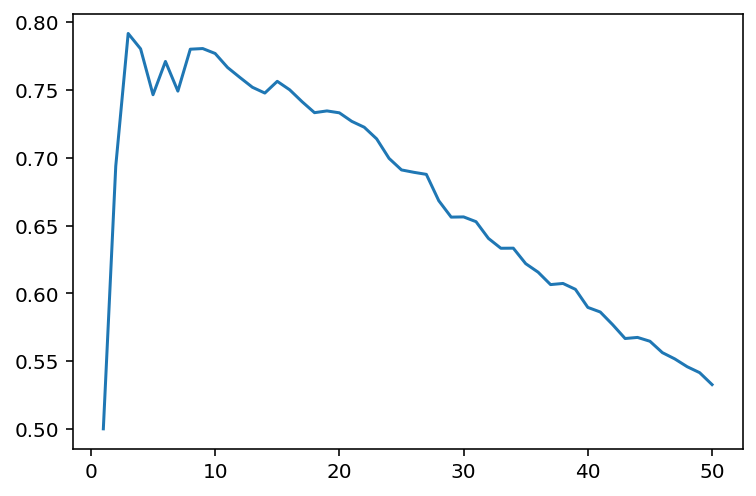

In [64]:
# 성능 정보 수집
result = []
for n in range(1, 51, 1) :
    model = KNeighborsRegressor(n_neighbors=n)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(r2_score(y_test, y_pred))
print(result)

# 시각화
plt.plot(list(range(1, 51, 1)), result)
plt.show()

> 성능이 올라가다가 쭉 떨어지고 있다.

# 5.기타

- 기타 필요한 내용이 있으면 진횅합니다.

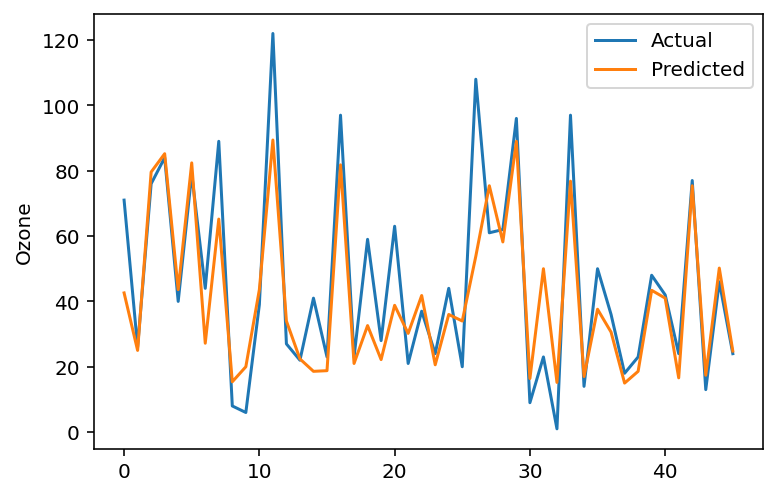

In [18]:
# 예측값, 실제값 시각화
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.ylabel('Ozone')
plt.show()